In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
import gitfame

In [2]:
# print the gitfame data for the repo
gitfame.main(['--sort=commits', '-wt'])

Processing: 100%|██████████| 1/1 [00:00<00:00,  4.17file/s]

Total .ipynb: 691
Total commits: 23
Total ctimes: 150
Total files: 3
Total loc: 691
| Author          |   loc |   coms |   fils |  distribution   |
|:----------------|------:|-------:|-------:|:----------------|
| marti000        |   466 |      8 |      1 | 67.4/34.8/33.3  |
| noayasmine      |   124 |      7 |      1 | 17.9/30.4/33.3  |
| matijsv         |   101 |      4 |      1 | 14.6/17.4/33.3  |
| Milo Vollmuller |     0 |      4 |      0 | 0.0/17.4/ 0.0   |


Part 1: Implementing and plotting the Mandelbrot set

In [3]:
# hyperparameters
# bounds for the search space [x,y]
lowerBounds = [-2.0, -1.5]
upperBounds = [1.0, 1.5]

In [4]:
def mandelbrot(c, max_iter):
    '''
    Determines whether complex number c lies within the mandelbrot set via the escape time algorithm.
    
    Args:
        c (complex):    Complex number to be tested.
        max_iter (int): Number of iterations to perform.
        
    Returns:
        z (complex): The complex number at iteration max_iter.
        n (int): The number of iterations before the escape condition is reached.
    '''
    z = 0 + 0j
    n = 0
    while abs(z) <= 2 and n < max_iter:
        z = z*z + c
        n += 1
        
    return z, n

def plot_mandelbrot(width, height, max_iter):
    '''
    Plots the Mandelbrot set at a given resolution and number of iterations.
    
    Args:
        width (int):    width of generated image in pixels.
        height (int):   height of generated image in pixels.
        max_iter (int): maximum number of iterations to be performed when calculating the set.
    
    Returns:
        None
    '''
    
    # Set arrays to store the mandelbrot set
    x, y = np.linspace(lowerBounds[0], upperBounds[0], width), np.linspace(lowerBounds[1], upperBounds[1], height)
    mandelbrot_set = np.empty((height, width))
    mandelbrot_set_bool = np.empty((height, width))
    
    # Calculate the mandelbrot set
    for i in range(height):
        for j in range(width):
            z, mandelbrot_set[i, j] = mandelbrot(x[j] + 1j * y[i], max_iter)
            if abs(z) <= 2:
                mandelbrot_set_bool[i, j] = 1
            else:
                mandelbrot_set_bool[i, j] = 0
    
    plt.figure(figsize=(10, 10))
    plt.imshow(mandelbrot_set, extent=(lowerBounds[0], upperBounds[0], lowerBounds[1], upperBounds[1]),
               cmap='inferno', interpolation='bilinear')
    plt.colorbar()
    plt.title("Mandelbrot Set")
    plt.xlabel("Re")
    plt.ylabel("Im")
    plt.show()
    
    print(mandelbrot_set_bool)
    plt.figure(figsize=(10, 10))
    plt.imshow(mandelbrot_set_bool)
    plt.colorbar()
    plt.title("Mandelbrot Set")
    plt.xlabel("Re")
    plt.ylabel("Im")
    plt.show()

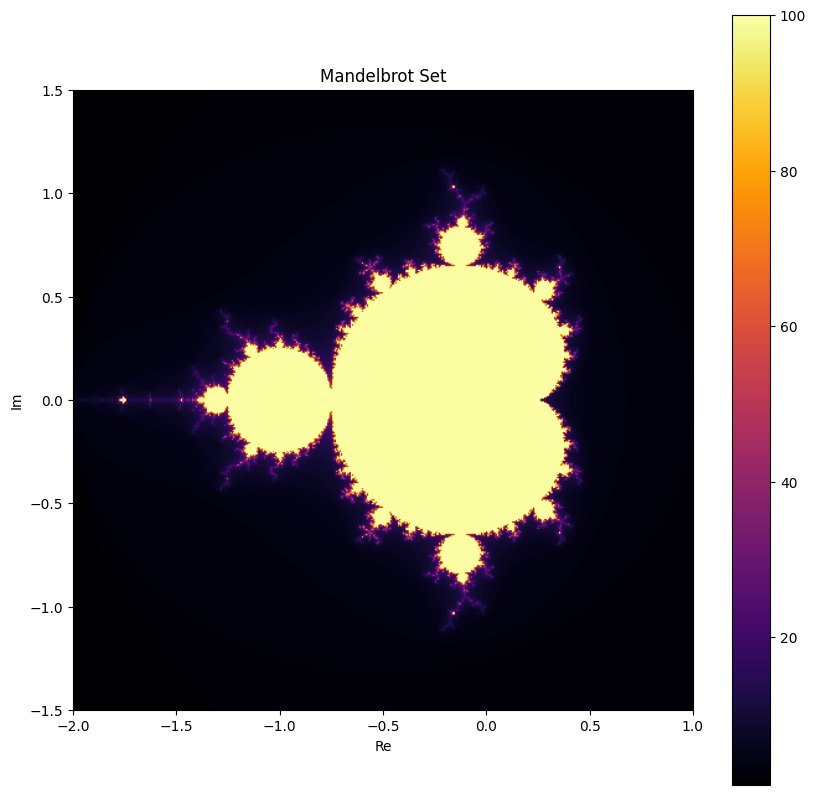

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


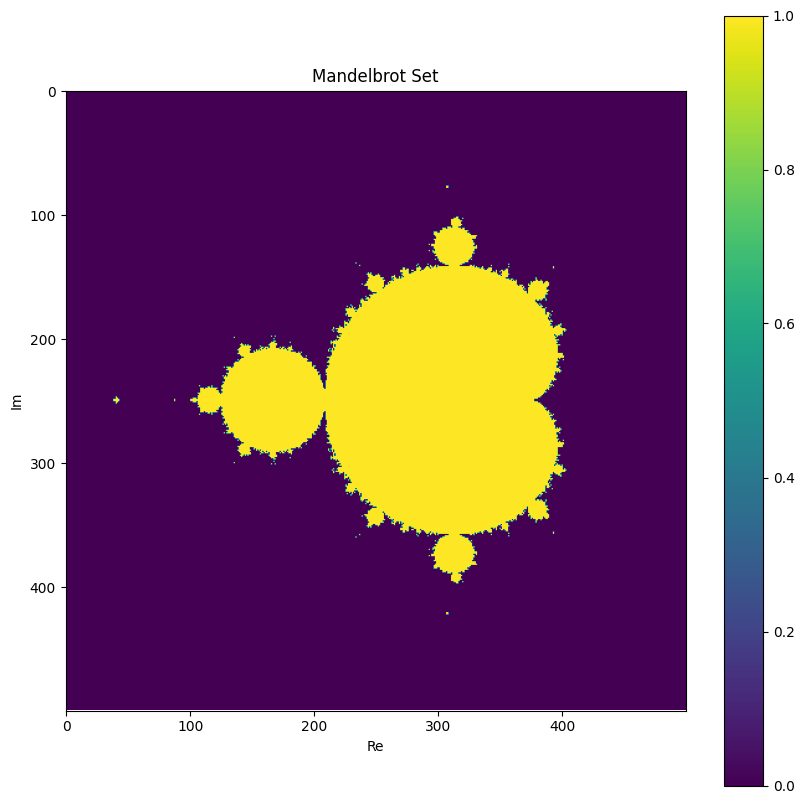

In [5]:
# Plot the Mandelbrot set with given parameters
plot_mandelbrot(500, 500, 100)

Part 2

In [6]:
def get_random_sample(sample_size,sampling_method="random",seed=42):
    '''	
    Generate a random sample of points in the square defined by lowerBounds and upperBounds.

    Args:
        sample_size (int): Number of points to sample.
        sampling_method (str): Method to use for sampling. Options are "random", "latin", "orthogonal".

    Returns:
        sample_scaled (numpy.ndarray): Array of shape (sample_size, 2) containing the sampled points.
    '''
    np.random.seed(seed)

    # use latin hypercube sampling to sample points in the square
    if sampling_method == "latin":
        sampler = qmc.LatinHypercube(d=2,strength=1)
        sample = sampler.random(sample_size)
        sample_scaled = qmc.scale(sample, lowerBounds, upperBounds)

    # number of points needs to be p**2 where p is a prime number
    if sampling_method == "orthogonal":
        sampler = qmc.LatinHypercube(d=2,strength=2)
        sample = sampler.random(sample_size)
        sample_scaled = qmc.scale(sample, lowerBounds, upperBounds)
    
    # use pure random sampling
    if sampling_method == "random":
        sample_scaled = np.random.uniform(low=lowerBounds, high=upperBounds, size=(sample_size, 2))

    # use rejection sampling
    if sampling_method == "rejection":
        samples = []
        while len(samples) < sample_size:
            # sample from a normal distribution
            sample = np.random.normal(loc=[0, 0], scale=[1, 1])
            # scale the sample to the desired distribution
            scaled_sample = sample * np.array([1, 0.5]) + np.array([0, 1])
            # check if the sample is within the desired region
            if lowerBounds[0] <= scaled_sample[0] <= upperBounds[0] and lowerBounds[1] <= scaled_sample[1] <= upperBounds[1]:
                samples.append(scaled_sample)
        sample_scaled = np.array(samples)
    
    return sample_scaled

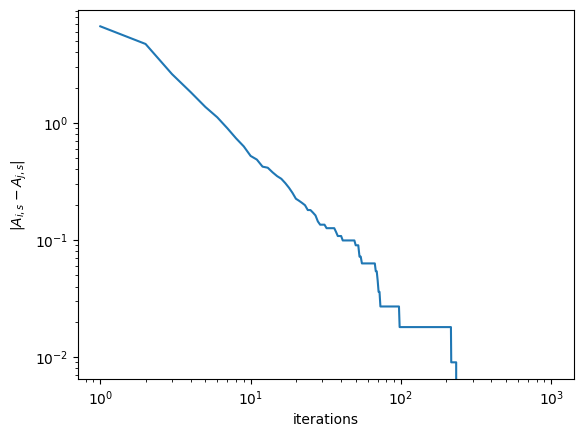

In [7]:
sample_size = 1000
sample_scaled = get_random_sample(sample_size)
max_iter = 1000

# check MC for one value of max_iter, do for multiple sample sizes
area_of_region = abs(upperBounds[0] - lowerBounds[0]) * abs(upperBounds[1] - lowerBounds[1]) 
areas = []
for iter in range(max_iter):
    mc_count = 0
    
    for i in range(sample_size):
            z, _ = mandelbrot(sample_scaled[i][0] + 1j * sample_scaled[i][1], iter)
        
            if abs(z) <= 2:
                mc_count += 1
            
    current_area = (float(mc_count) * area_of_region) / sample_size
    areas.append(current_area)

areas = np.array(areas)

plt.figure()
plt.ylabel(r"|$A_{i,s} - A_{j,s}$|")
plt.xlabel("iterations")
plt.plot(np.arange(1,max_iter,1),abs(areas-areas[-1])[1::])
plt.yscale("log")
plt.xscale("log")

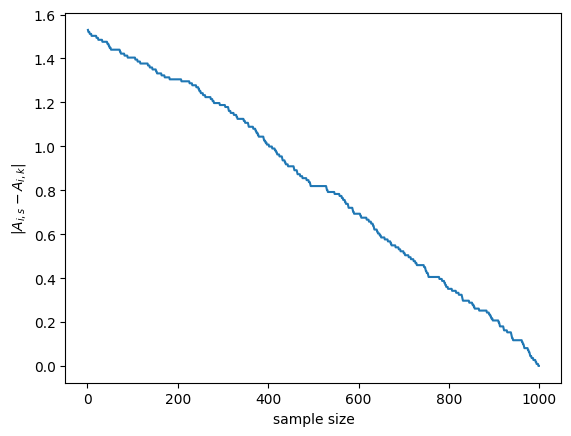

In [8]:
sample_size = 1000
sample_scaled = get_random_sample(sample_size)
max_iter = 1000

# Not sure abt this part still, probably we don't need this (estimate error on s theoretically)
area_of_region = abs(upperBounds[0] - lowerBounds[0]) * abs(upperBounds[1] - lowerBounds[1]) 
areas = []
for s in range(sample_size):
    mc_count = 0
    
    for i in range(s):
            z, _ = mandelbrot(sample_scaled[i][0] + 1j * sample_scaled[i][1], iter)
        
            if abs(z) <= 2:
                mc_count += 1
            
    current_area = (float(mc_count) * area_of_region) / sample_size
    areas.append(current_area)

areas = np.array(areas)

plt.figure()
plt.ylabel(r"|$A_{i,s} - A_{i,k}$|")
plt.xlabel("sample size")
plt.plot(np.arange(1,sample_size,1),abs(areas-areas[-1])[1::])
#plt.yscale("log")
#plt.xscale("log")

KeyboardInterrupt: 

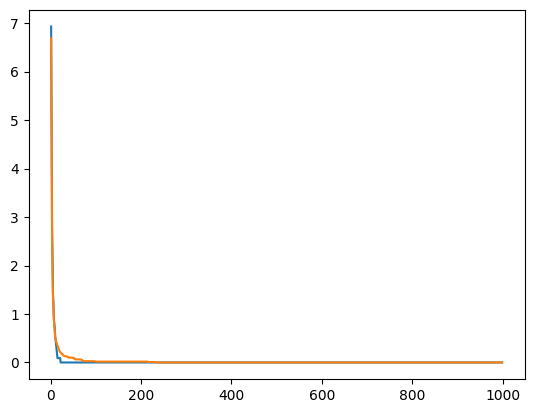

In [9]:
area_of_region = abs(upperBounds[0] - lowerBounds[0]) * abs(upperBounds[1] - lowerBounds[1]) 
max_iter = 1000
sample_sizes = [100,1000,10000]

plt.figure()
# we can do this for multiple runs to get a confidence
# check MC for one value of max_iter, do for multiple sample sizes
for sample_size in sample_sizes:
    # get a random sample
    sample_scaled = get_random_sample(sample_size)
    areas = []

    # find area and convergence to area for given maximal iterations and sample size
    for iter in range(max_iter):
        mc_count = 0
        
        for i in range(sample_size):
                z, _ = mandelbrot(sample_scaled[i][0] + 1j * sample_scaled[i][1], iter)
            
                if abs(z) <= 2:
                    mc_count += 1
                
        current_area = (float(mc_count) * area_of_region) / sample_size
        areas.append(current_area)

    areas = np.array(areas)

    plt.plot(np.arange(1,max_iter,1),abs(areas-areas[-1])[1::],label=f"{sample_size}")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.ylabel(r"|$A_{i,s} - A_{j,s}$|")
plt.xlabel("iterations")
plt.show()

Importance sampling

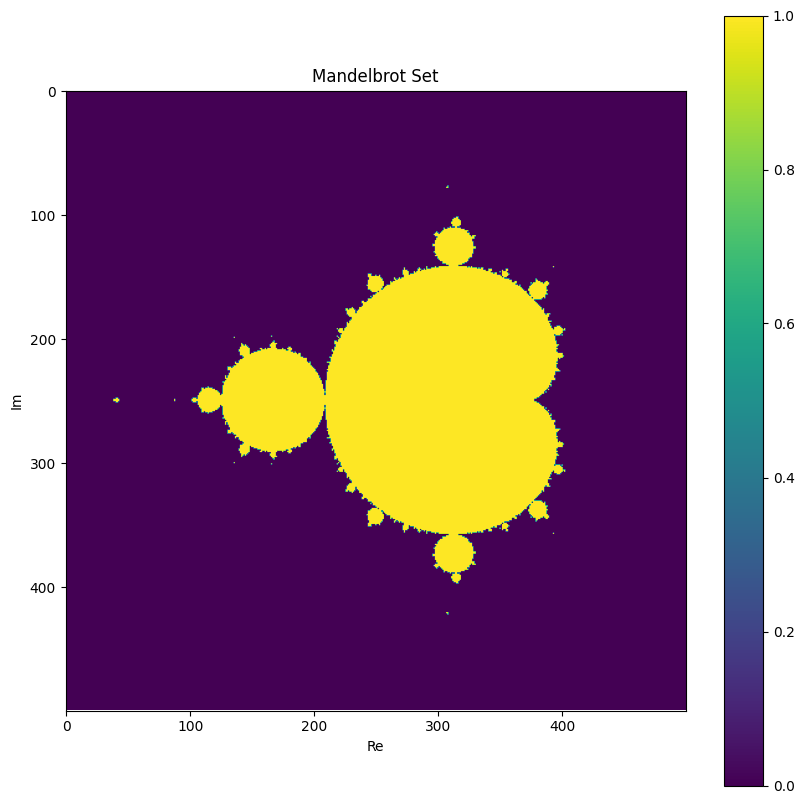

In [9]:
# create a precomputed map of the Mandelbrot set to identify boundary regions.
# this is a 2D array of size (width, height) with 1 if the point is in the Mandelbrot set and 0 otherwise
def precompute_mandelbrot(width, height, max_iter):
    '''
    Precomputes the Mandelbrot set at a given resolution and number of iterations.
    
    Args:
        width (int):    width of generated image in pixels.
        height (int):   height of generated image in pixels.
        max_iter (int): maximum number of iterations to be performed when calculating the set.
    
    Returns:
        mandelbrot_set_bool (numpy.ndarray): Array of shape (height, width) containing the Mandelbrot set.
    '''
    
    # Set arrays to store the mandelbrot set
    x, y = np.linspace(lowerBounds[0], upperBounds[0], width), np.linspace(lowerBounds[1], upperBounds[1], height)
    mandelbrot_set_bool = np.empty((height, width))
    
    # Calculate the mandelbrot set
    for i in range(height):
        for j in range(width):
            z, _ = mandelbrot(x[j] + 1j * y[i], max_iter)
            if abs(z) <= 2:
                mandelbrot_set_bool[i, j] = 1
            else:
                mandelbrot_set_bool[i, j] = 0
    
    return mandelbrot_set_bool

# plot the precomputed Mandelbrot set
mandelbrot_set_bool = precompute_mandelbrot(500, 500, max_iter)
plt.figure(figsize=(10, 10))
plt.imshow(mandelbrot_set_bool)
plt.colorbar()
plt.title("Mandelbrot Set")
plt.xlabel("Re")
plt.ylabel("Im")
plt.show()

[(77, 307), (78, 306), (78, 307), (102, 314), (102, 315), (103, 312), (103, 313), (103, 315), (104, 311), (104, 316), (105, 311), (105, 317), (106, 310), (106, 317), (107, 310), (107, 317), (108, 311), (108, 317), (109, 311), (109, 312), (109, 315), (109, 316), (110, 309), (110, 313), (110, 314), (111, 304), (111, 307), (111, 308), (111, 310), (111, 311), (111, 312), (111, 315), (111, 316), (111, 317), (112, 304), (112, 305), (112, 306), (112, 318), (112, 319), (112, 320), (113, 303), (113, 321), (113, 322), (113, 323), (114, 298), (114, 302), (114, 322), (115, 297), (115, 299), (115, 301), (115, 323), (115, 324), (116, 296), (116, 300), (116, 324), (117, 297), (117, 298), (117, 325), (117, 327), (117, 328), (117, 329), (118, 299), (118, 326), (118, 328), (119, 298), (119, 327), (119, 328), (120, 298), (120, 326), (121, 297), (121, 326), (122, 297), (122, 327), (123, 297), (123, 327), (124, 295), (124, 296), (124, 327), (125, 295), (125, 296), (125, 327), (126, 297), (126, 328), (126, 

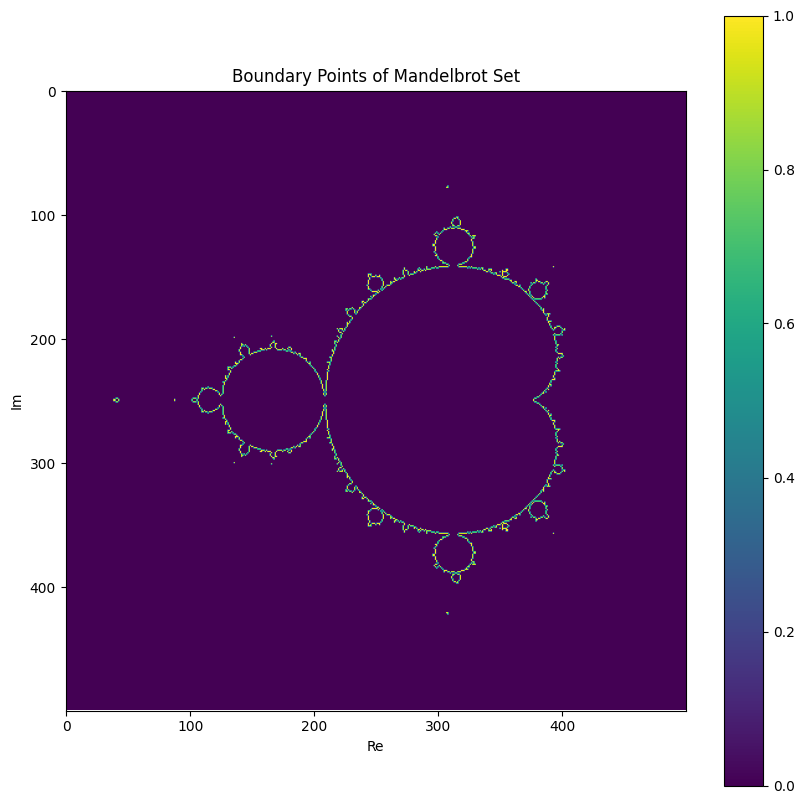

In [10]:
# use the precomputed map to identify boundary regions
def get_boundary_points(mandelbrot_set_bool):
    '''
    Identifies boundary points in the Mandelbrot set.
    
    Args:
        mandelbrot_set_bool (numpy.ndarray): Array of shape (height, width) containing the Mandelbrot set.
    
    Returns:
        boundary_points (list): List of tuples containing the coordinates of boundary points.
    '''
    
    boundary_points = []
    
    # iterate over the Mandelbrot set to find boundary points
    for i in range(1, mandelbrot_set_bool.shape[0] - 1):
        # check if the point is in the Mandelbrot set and has a neighbour that is not
        for j in range(1, mandelbrot_set_bool.shape[1] - 1):
            if mandelbrot_set_bool[i, j] == 1:
                if (mandelbrot_set_bool[i - 1, j] == 0 or mandelbrot_set_bool[i + 1, j] == 0 
                    or mandelbrot_set_bool[i, j - 1] == 0 or mandelbrot_set_bool[i, j + 1] == 0):
                    boundary_points.append((i, j))
    
    return boundary_points

# get the boundary points of the Mandelbrot set
boundary_points = get_boundary_points(mandelbrot_set_bool)
print(boundary_points)

# plot the boundary points
all_points = np.zeros(mandelbrot_set_bool.shape)
for point in boundary_points:
    all_points[point[0], point[1]] = 1

plt.figure(figsize=(10, 10))
plt.imshow(all_points)
plt.colorbar()
plt.title("Boundary Points of Mandelbrot Set")
plt.xlabel("Re")
plt.ylabel("Im")
plt.show()

In [11]:
# use this list of boundary points to assign a weight to each point in the sample
def get_weights(sample_scaled, boundary_points, bound_emphasis=1):
    '''
    Assigns a weight to each point in the sample based on its proximity to the closest boundary point.

    The distance function:
        d(x, y) = min ( sqrt((x - x_bp)^2 + (y - y_bp)^2) ) for all boundary points (x_bp, y_bp)

        Where (x, y) are the coordinates of a point in the sample and (x_bp, y_bp) are the coordinates of a boundary point.


    The weight function:
        w(x, y) = bound_emphasis * d(x, y)

        The bound_emphasis parameter can be used to adjust the influence of the boundary points on the weights.

    Normalization:
        The weights are normalized such that the sum of all weights sums to 1.

    Args:
        sample_scaled (numpy.ndarray): Array of shape (sample_size, 2) containing the sampled points.
        boundary_points (list): List of tuples containing the coordinates of boundary points.
    
    Returns:
        weights (numpy.ndarray): Array of shape (sample_size,) containing the weights of each point in the sample.
    '''
    
    # initialize the weights array
    weights = np.zeros(sample_scaled.shape[0])

    # iterate over the sample to calculate the weights
    for i in range(sample_scaled.shape[0]):
        x, y = sample_scaled[i]
        min_distance = np.inf
        
        # find the closest boundary point
        for point in boundary_points:
            x_bp, y_bp = point
            distance = np.sqrt((x - x_bp)**2 + (y - y_bp)**2)
            if distance < min_distance:
                min_distance = distance
        
        # assign the weight to the sample point
        weights[i] = bound_emphasis * min_distance

    # normalize the weights
    weights /= np.sum(weights)
    
    return weights

In [12]:
def sample_on_weight(sample, weights, sample_size):
    '''
    Samples points from the given sample based on the weights assigned to each point.

    Args:
        sample: Array containing the sampled points.
        weights: Array containing the weights of each point in the sample.
        sample_size: Number of points to sample.
    
    Returns:
        sample_weighted: Array containing the sampled points based on the weights.
    '''
    
    # sample points based on the weights
    sample_weighted = sample[np.random.choice(sample.shape[0], size=sample_size, p=weights)]
    
    return sample_weighted

In [13]:
# generate random sample
seed = 42
n_initial = 10000
n_weighted = 1000
sample = get_random_sample(n_initial, sampling_method="random", seed=seed)
sample_weights = get_weights(sample, boundary_points)
weighted_sample = sample_on_weight(sample, sample_weights, n_weighted)

In [17]:
def find_area(sample):
    '''
    '''
    # find area and convergence to area for given maximal iterations and sample size
    mc_count = 0
    area_of_region = abs(upperBounds[0] - lowerBounds[0]) * abs(upperBounds[1] - lowerBounds[1])

    for i in range(sample.shape[0]):
        z, _ = mandelbrot(sample[i][0] + 1j * sample[i][1], max_iter)
        
        if abs(z) <= 2:
            mc_count += 1

    current_area = (float(mc_count) * area_of_region) / sample.shape[0]

    # plot convergence
    plt.figure()
    plt.plot(np.arange(1,max_iter,1),abs(areas-areas[-1])[1::])
    plt.yscale("log")
    plt.xscale("log")
    plt.ylabel(r"|$A_{i,s} - A_{j,s}$|")
    plt.xlabel("iterations")
    plt.show()

    return current_area

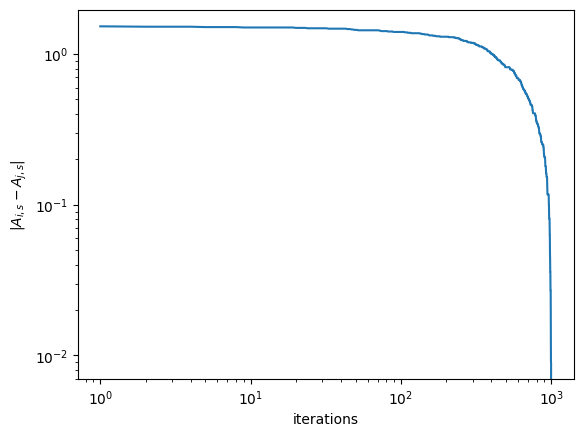

Area of Mandelbrot set for weighted sample: 1.548


In [19]:
# calculate the area of the Mandelbrot set for the random sample and the weighted sample
area_weighted = find_area(weighted_sample)
print(f"Area of Mandelbrot set for weighted sample: {area_weighted}")